In [2]:
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver import Firefox
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import numpy as np
import time

## Creating a webdriver and scrolling/clicking through

In [28]:
driver = webdriver.Firefox()
driver.maximize_window()
driver.get("https://www.mathem.se/avdelning/extrapriser")

time.sleep(2)

element = driver.find_element(By.CSS_SELECTOR, 'button.btn:nth-child(1) > span:nth-child(1)')
element.click()

element = driver.find_element(By.CSS_SELECTOR, '.btn > span:nth-child(1)')
counter = 1
while element and counter < 5:
    
    driver.execute_script(f"window.scrollTo(0,{5700 * counter})")

    time.sleep(1)
    
    element = driver.find_element(By.CSS_SELECTOR, '.btn > span:nth-child(1)')
    element.click()
    
    counter += 1



## Scraping the page

In [30]:
def item_extract(item_cont, key):
    """Item_cont is the i when looping through a
    container and key is the css selector tag for 
    a specific element"""
    #parse = item_cont.select(key)
    parse = item_cont.find_elements(By.CSS_SELECTOR, key)
    if parse == []:
        return np.nan
    else:
        return parse[0].text

In [58]:
elements = driver.find_elements(By.CSS_SELECTOR, ".product-grid > li > mh-product > mathem-product-card")
orig_price = []
sales_price = []
names = []
price = []
for container in elements:
    
    orig_price.append(item_extract(container, "span.pcp__original"))
    sales_price.append(item_extract(container, "span.pcp__price"))
    names.append(item_extract(container, "a.product-card__hitarea"))
    

In [59]:
len(sales_price)

152

In [60]:
len(elements)

152

In [61]:
len(orig_price)

152

In [62]:
len(names)

152

In [63]:
sales_prices = [i for i in sales_price]
orig_prices = [i for i in orig_price]

In [64]:
df = {
    'names': names,
    'sales_price': sales_price,
    'original_price': orig_price
     }

In [65]:
df = pd.DataFrame(df)

In [66]:
len(df)

152

In [67]:
len(df.dropna())

152

In [68]:
df

,names,sales_price,original_price
0,Apelsin Klass1,10:-,10:95
1,Apelsinjuice med Bitar,25:- +pant,36:95
2,Rengöringsspray Badrum,25:-,29:95
3,Yoghurt Rabarber & Vanilj 2%,25:-,30:95
4,Aioli,22:-,27:95
...,...,...,...
147,"Ekulf, pH Supreme 0,45mm",24:-,32:95
148,"CCS Foot Bath Liquid Blue, Fotbad. 250 ml",75:-,99:95
149,CCS Warming foot cream,104:-,129:-
150,"Neutrogena Oil Balancing Facial Wash, Ansiktsr...",70:-,93:95


## Data Cleaning

In [71]:
df.original_price = df["original_price"].str.replace(":-", "")

In [76]:
df.original_price = df.original_price.str.replace(":", ",")

In [78]:
df.original_price = df.original_price.str.replace(",", ".")

In [79]:
df.original_price = df.original_price.astype(float)

In [80]:
df.sales_price = df.sales_price.str.replace(":-", "")

In [81]:
df.sales_price = df.sales_price.str.replace(":", ".")

In [83]:
df.sales_price = df.sales_price.str.replace("+pant", "")

In [84]:
df.sales_price = df.sales_price.astype(float)

In [101]:
df.describe()

,sales_price,original_price,percentage_saved
count,152.000000,152.000000,152.000000
mean,84.098684,108.300000,21.535270
std,72.203654,93.926243,5.377641
min,10.000000,10.950000,4.217298
25%,30.000000,38.450000,18.212930
50%,55.000000,69.950000,21.372409
75%,116.000000,141.500000,25.408566
max,355.000000,475.000000,35.125116


In [86]:
df["percentage_saved"] = 100 * ((df.original_price - df.sales_price)/df.original_price)

In [102]:
df.head()

,names,sales_price,original_price,percentage_saved
16,Maskindiskmedel 40-Pack 40-p,35.0,53.95,35.125116
5,Biskvi Choklad 6-p,19.5,29.95,34.891486
22,Kokosboll Laktos- & Glutenfri Utan Tillsatt So...,19.5,29.95,34.891486
1,Apelsinjuice med Bitar,25.0,36.95,32.341001
93,"Ekulf Fuktisar Lemon, Sugtablett, 30 st",39.0,56.95,31.518876


In [88]:
df.sort_values(by = "percentage_saved", ascending = False, inplace = True)

In [89]:
df

,names,sales_price,original_price,percentage_saved
16,Maskindiskmedel 40-Pack 40-p,35.0,53.95,35.125116
5,Biskvi Choklad 6-p,19.5,29.95,34.891486
22,Kokosboll Laktos- & Glutenfri Utan Tillsatt So...,19.5,29.95,34.891486
1,Apelsinjuice med Bitar,25.0,36.95,32.341001
93,"Ekulf Fuktisar Lemon, Sugtablett, 30 st",39.0,56.95,31.518876
...,...,...,...,...
75,"SB12 Tandkräm, Tandkräm, 100 ml",86.0,94.95,9.426014
101,"Ekulf PH Professional 0,6 mm, Mellanrumsborste...",39.0,42.95,9.196740
0,Apelsin Klass1,10.0,10.95,8.675799
135,"Neutrogena Grape Moisturiser, Ansiktskräm, 50 ml",71.0,75.95,6.517446


## Data Analysis

### Mean savings for bins

In [91]:
bins = [0,10,20,50,100,200]

groups = pd.cut(df['original_price'], bins)

mean_savings = df.groupby(groups)["percentage_saved"].mean()
savings_per_group = pd.DataFrame(mean_savings)
savings_per_group

,percentage_saved
original_price,
"(0, 10]",NaN
"(10, 20]",18.005005
"(20, 50]",19.933715
"(50, 100]",22.066514
"(100, 200]",22.429361


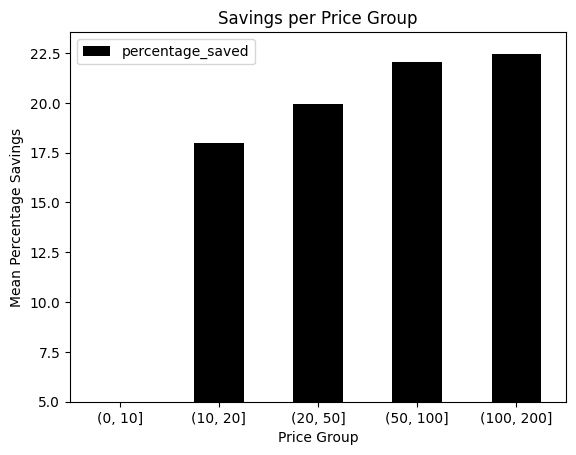

In [92]:
import matplotlib.pyplot as plt

# Assuming the DataFrame is stored in a variable called "df"
ax = savings_per_group.plot.bar(rot=0, color = "black")
ax.set_ylim(bottom = 5)
ax.set_xlabel("Price Group")
ax.set_ylabel("Mean Percentage Savings")
ax.set_title("Savings per Price Group")

plt.show()

### Count per Bin

In [94]:
bins = pd.cut(df['percentage_saved'], bins= [0, 10, 20, 30, 40, 50])
grouped = df.groupby(bins)
counts = grouped.size()
saving_groups = pd.DataFrame(counts, columns=['count'])

saving_groups

,count
percentage_saved,
"(0, 10]",5
"(10, 20]",53
"(20, 30]",86
"(30, 40]",8
"(40, 50]",0


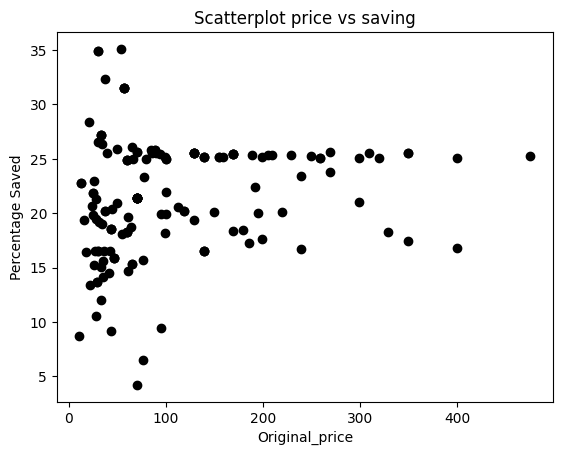

In [97]:
plt.scatter(df['original_price'], df['percentage_saved'], color = 'black')
plt.xlabel('Original_price')
plt.ylabel('Percentage Saved')
plt.title('Scatterplot price vs saving')
plt.show()

### Count per bin

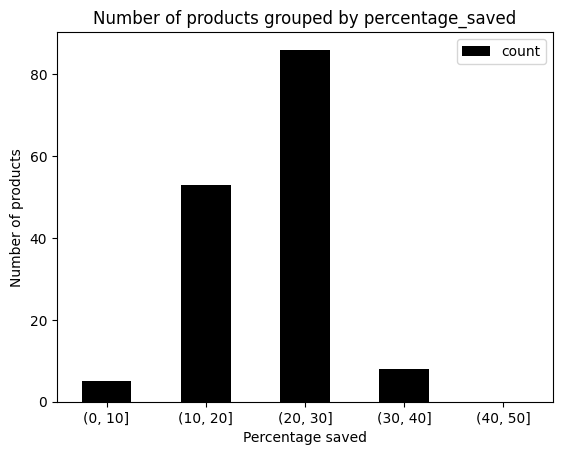

In [100]:
import matplotlib.pyplot as plt


ax = saving_groups.plot.bar(rot = 0, color = "black")
#ax.set_ylim(bottom = 5)
ax.set_xlabel("Percentage saved")
ax.set_ylabel("Number of products")
ax.set_title("Number of products grouped by percentage_saved")

plt.show()